In [131]:
#imports and checks
import os, sys, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Expected paths (edit if your structure is different)
UCI_DIR = "./UCI HAR Dataset"
assert os.path.isdir(UCI_DIR), "UCI HAR Dataset folder not found next to this notebook."

print("OK: Found", UCI_DIR)

OK: Found ./UCI HAR Dataset


In [132]:
%run -i ./CombineScript.py

Done Combining the training data
Done Combining the testing data
Done Combining the data


In [133]:
%run -i ./MakeDataset.py

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)


In [134]:
print("X (all) shape:", X.shape, "y shape:", y.shape)
print("Train:", X_train.shape, y_train.shape, " | Test:", X_test.shape, y_test.shape)
inv_classes = {v:k for k,v in classes.items()}
print("Label map:", inv_classes)

X (all) shape: (180, 500, 3) y shape: (180,)
Train: (126, 500, 3) (126,)  | Test: (54, 500, 3) (54,)
Label map: {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [135]:
import numpy as np
ACTIVITY_ORDER = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
ACTIVITY_TO_ID = {name: classes[name] for name in ACTIVITY_ORDER}
ID_TO_ACTIVITY = {v:k for k,v in ACTIVITY_TO_ID.items()}

def get_one_index_per_activity(y_array, order=ACTIVITY_ORDER):
    idxs = []
    for act in order:
        label = ACTIVITY_TO_ID[act]
        i = np.where(y_array == label)[0][0]
        idxs.append(i)
    return idxs

def acc_magnitude(batch_xyz):  
    v = batch_xyz
    return (v[...,0]**2) + (v[...,1]**2) + (v[...,2]**2)

def color_for_activity(activity):
    palette = {
        "LAYING":"#1f77b4","SITTING":"#ff7f0e","STANDING":"#2ca02c",
        "WALKING":"#d62728","WALKING_DOWNSTAIRS":"#9467bd","WALKING_UPSTAIRS":"#8c564b"
    }
    return palette[activity]


**Q1.** Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data?

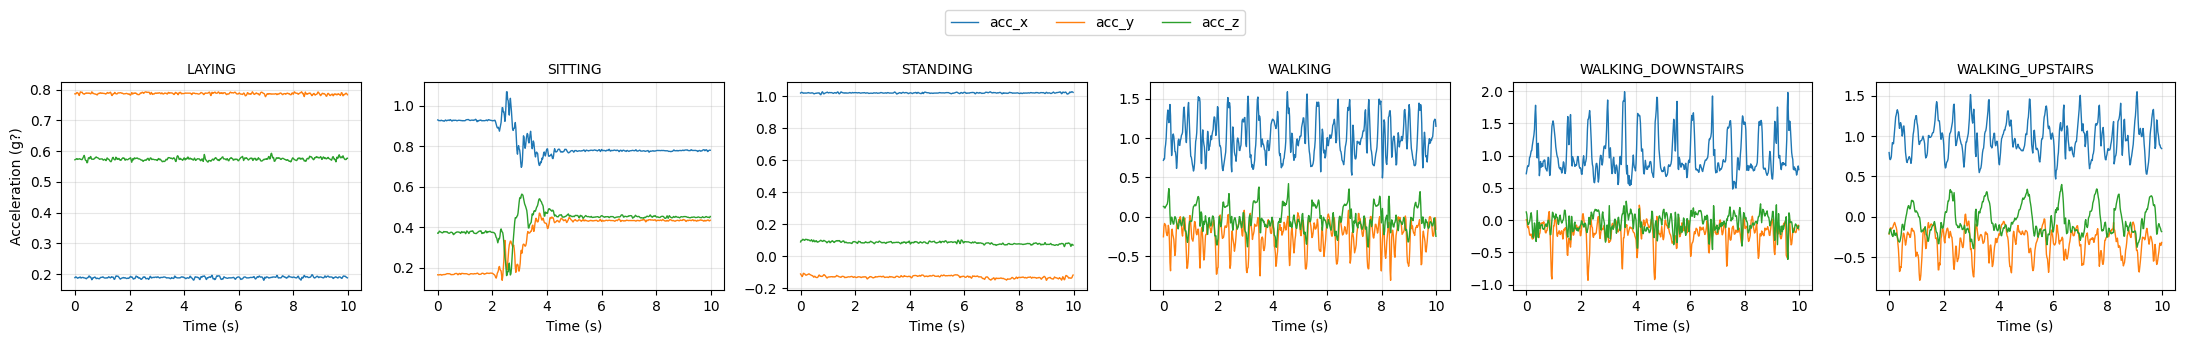

In [136]:
sel = get_one_index_per_activity(y, ACTIVITY_ORDER)
X_sel = X[sel]   
y_sel = y[sel]

fig, axes = plt.subplots(1, 6, figsize=(22, 3), sharex=True, sharey=False)
t = np.arange(500) / 50.0  

for i, ax in enumerate(axes):
    act = ID_TO_ACTIVITY[y_sel[i]]
    sig = X_sel[i]  
    ax.plot(t, sig[:,0], lw=1, label="acc_x")
    ax.plot(t, sig[:,1], lw=1, label="acc_y")
    ax.plot(t, sig[:,2], lw=1, label="acc_z")
    ax.set_title(act, fontsize=10)
    ax.set_xlabel("Time (s)")
    if i == 0:
        ax.set_ylabel("Acceleration (g?)")
    ax.grid(alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.15))
plt.tight_layout()
plt.show()

Inference: We see that static activities (laying/sitting/standing) tend to look flatter while the dynamic ones (walking/stairs) show rhythmic oscillations. That pattern hints a model can separate them.

**Q2.** Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2+acc_y^2+acc_z^2)$ for each activity and justify your answer.

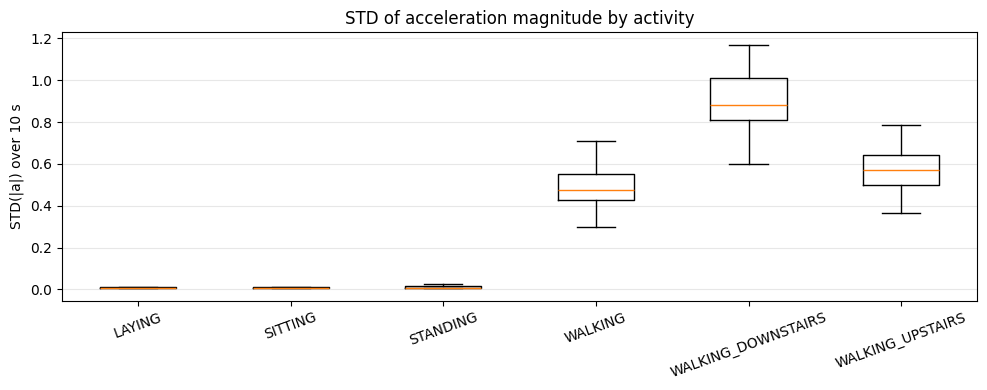

                    std_mag  mean_mag
activity                             
LAYING               0.0108    1.0108
SITTING              0.0095    1.0292
STANDING             0.0119    1.0655
WALKING              0.4886    1.1549
WALKING_DOWNSTAIRS   0.8908    1.2270
WALKING_UPSTAIRS     0.5777    1.1593


In [137]:
mag_all = acc_magnitude(X)  

std_per_sample = mag_all.std(axis=1)
mean_per_sample = mag_all.mean(axis=1)

df_stats = pd.DataFrame({
    "activity": [ID_TO_ACTIVITY[i] for i in y],
    "std_mag": std_per_sample,
    "mean_mag": mean_per_sample
})

fig, ax = plt.subplots(figsize=(10,4))
data_in_order = [df_stats.loc[df_stats.activity==act, "std_mag"].values for act in ACTIVITY_ORDER]
ax.boxplot(data_in_order, labels=ACTIVITY_ORDER, showfliers=False)
ax.set_title("STD of acceleration magnitude by activity")
ax.set_ylabel("STD(|a|) over 10 s")
ax.grid(alpha=0.3, axis="y")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

static = {"LAYING","SITTING","STANDING"}
dynamic = {"WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"}
print(df_stats.groupby("activity")[["std_mag","mean_mag"]].mean().round(4))

Inference: We do not need a complex machine learning model to separate static from dynamic activities. A simple threshold on the standard deviation of the acceleration magnitude (or even variance) is enough to clearly split the two groups. But we do need ML to further distinguish between activities inside each group.

**Q3.** Visualize the data using PCA.
* Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities. 
*  Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities. 
*  Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.
*  Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?

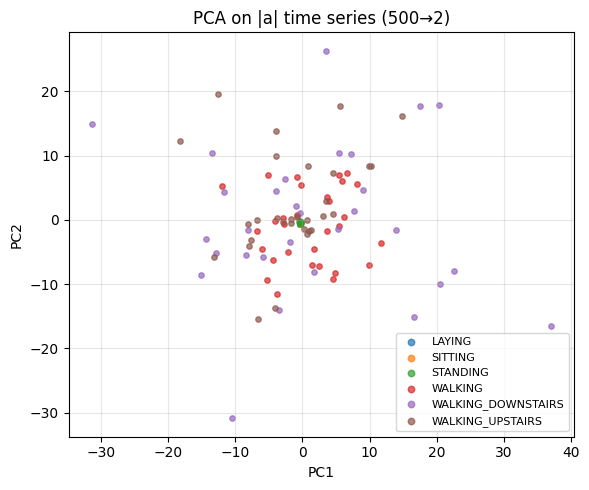

In [125]:

X_mag = mag_all 
X_mag_std = StandardScaler().fit_transform(X_mag)  

pca = PCA(n_components=2, random_state=42)
X_mag_pca = pca.fit_transform(X_mag_std)


fig, ax = plt.subplots(figsize=(6,5))
for act in ACTIVITY_ORDER:
    mask = (y == ACTIVITY_TO_ID[act])
    ax.scatter(X_mag_pca[mask,0], X_mag_pca[mask,1], s=15, alpha=0.7, label=act, c=color_for_activity(act))
ax.set_title("PCA on |a| time series (500→2)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(markerscale=1.2, fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Final feature shape: (126, 468)


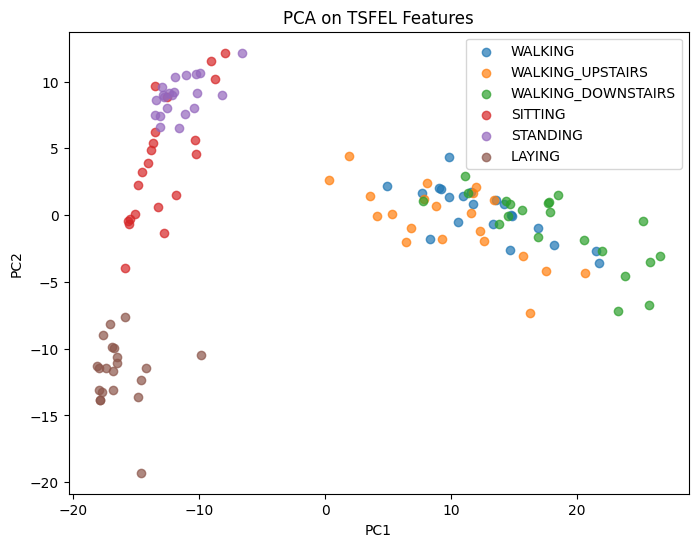

In [126]:

cfg = tsfel.get_features_by_domain()
activities = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]
classes = {act:i+1 for i, act in enumerate(activities)}  
base_path = "Combined/Train"

X, y = [], []

for act in activities:
    folder = os.path.join(base_path, act)
    for file in os.listdir(folder):
        df = pd.read_csv(os.path.join(folder, file))
        df = df.values[:500]   
        features = tsfel.time_series_features_extractor(cfg, df, verbose=0)
        X.append(features.values.flatten())
        y.append(classes[act])

X = np.array(X)
y = np.array(y)

X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

print("Final feature shape:", X.shape)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for act in activities:
    idx = [i for i, a in enumerate(y) if a==classes[act]]
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=act, alpha=0.7)

plt.legend()
plt.title("PCA on TSFEL Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Official features shape: (10299, 561)


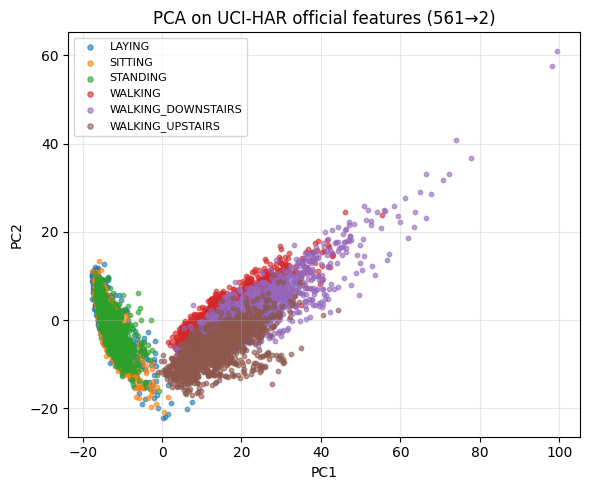

In [96]:
# C — PCA on official UCI-HAR features (561-D)
feat_names_path = os.path.join(UCI_DIR, "features.txt")
Xtr_path = os.path.join(UCI_DIR, "train", "X_train.txt")
ytr_path = os.path.join(UCI_DIR, "train", "y_train.txt")
Xte_path = os.path.join(UCI_DIR, "test", "X_test.txt")
yte_path = os.path.join(UCI_DIR, "test", "y_test.txt")

feat_names = pd.read_csv(feat_names_path, sep=r"\s+", header=None, names=["idx","name"])["name"].tolist()
X_tr = pd.read_csv(Xtr_path, delim_whitespace=True, header=None)
y_tr = pd.read_csv(ytr_path, delim_whitespace=True, header=None)[0].values
X_te = pd.read_csv(Xte_path, delim_whitespace=True, header=None)
y_te = pd.read_csv(yte_path, delim_whitespace=True, header=None)[0].values

X_uci = pd.concat([X_tr, X_te], axis=0).values  # (n, 561)
y_uci = np.concatenate([y_tr, y_te], axis=0)    # labels in 1..6
print("Official features shape:", X_uci.shape)

# Standardize & PCA
X_uci_std = StandardScaler().fit_transform(X_uci)
X_uci_pca = PCA(n_components=2, random_state=42).fit_transform(X_uci_std)

# scatter
fig, ax = plt.subplots(figsize=(6,5))
for act in ACTIVITY_ORDER:
    lab = ACTIVITY_TO_ID[act]
    mask = (y_uci == lab)
    ax.scatter(X_uci_pca[mask,0], X_uci_pca[mask,1], s=10, alpha=0.6, label=act, c=color_for_activity(act))
ax.set_title("PCA on UCI-HAR official features (561→2)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(markerscale=1.2, fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Inference:

1. Total Acceleration (raw data): The PCA projection looks very cluttered. Points from different activities overlap heavily. Raw time-series values are highly redundant and noisy, making PCA less effective. Poor separation of static vs dynamic activities.

2. TSFEL Features: The extracted features are richer: they capture statistical, temporal, and spectral properties. After PCA, clusters for activities are much more distinct. Dynamic activities (walking, upstairs, downstairs) form better-separated groups compared to raw signals. Still, some overlap remains between sitting vs standing.

3. Dataset Features (mean, std, etc.): Simpler features compared to TSFEL. PCA provides a clean separation between static and dynamic. Within-class overlap is higher, especially between walking vs walking upstairs.

**Q4.** Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features?

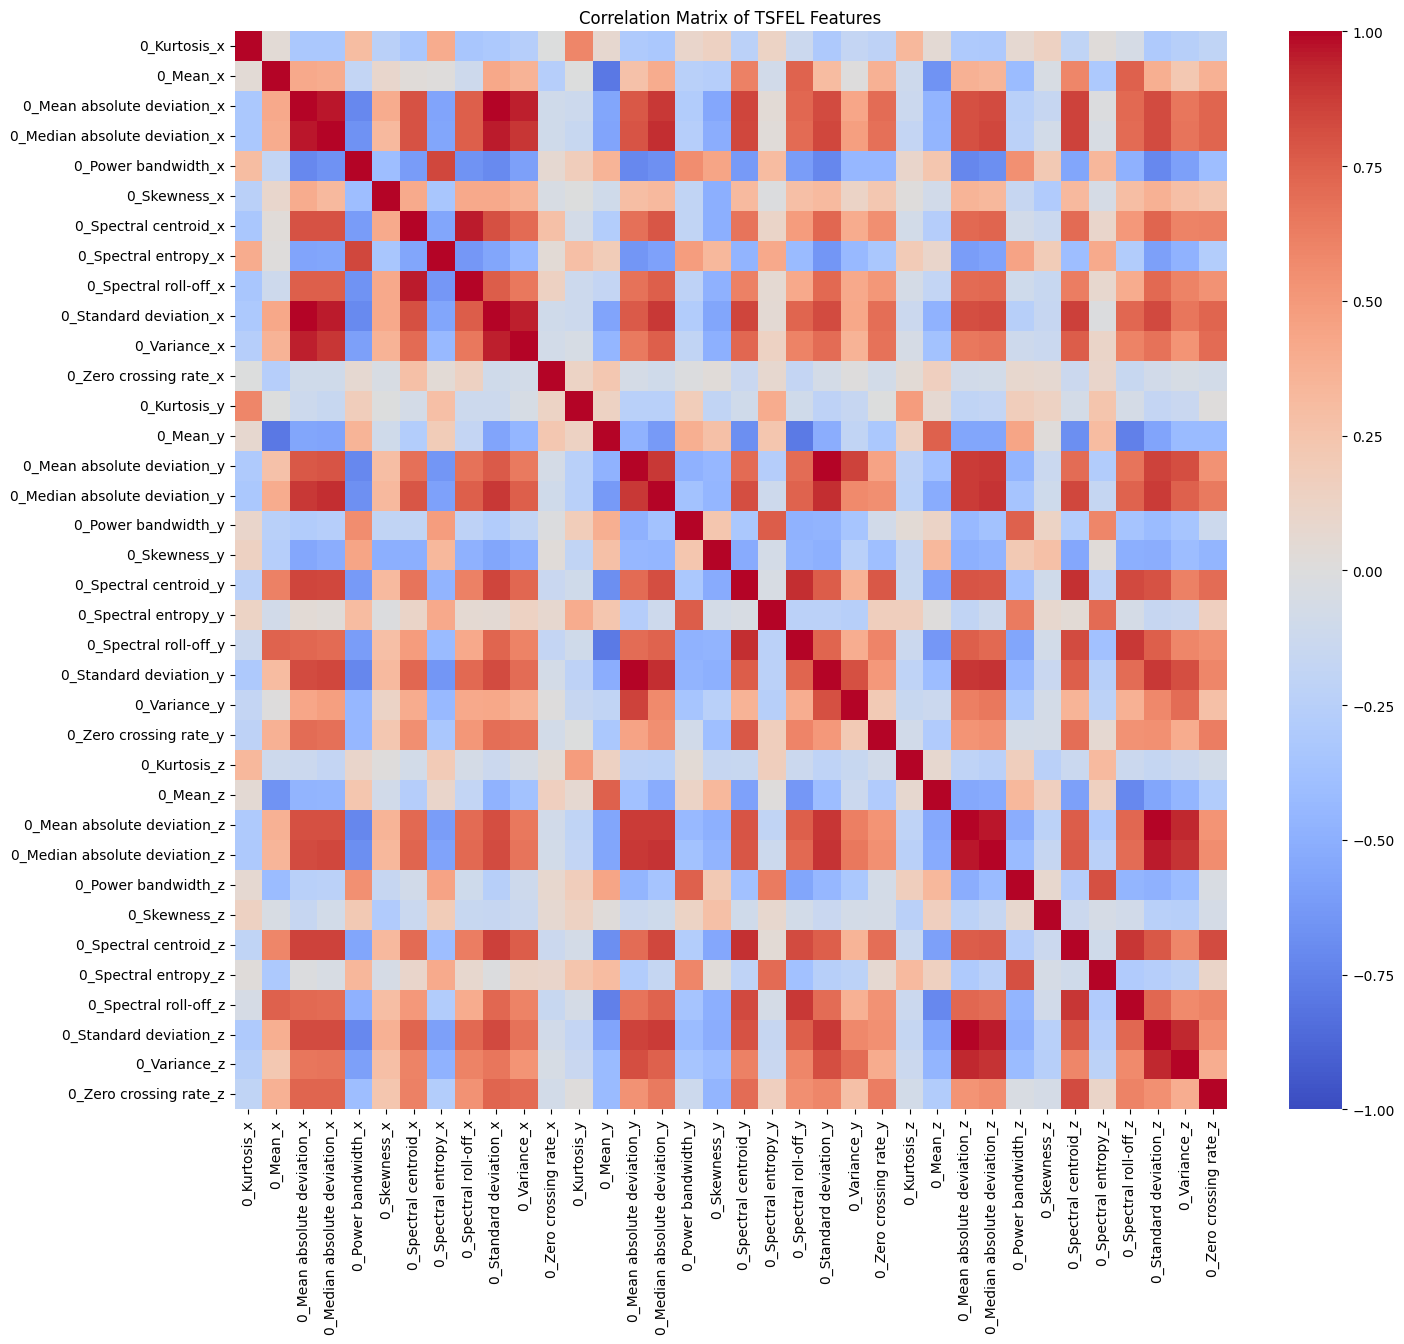

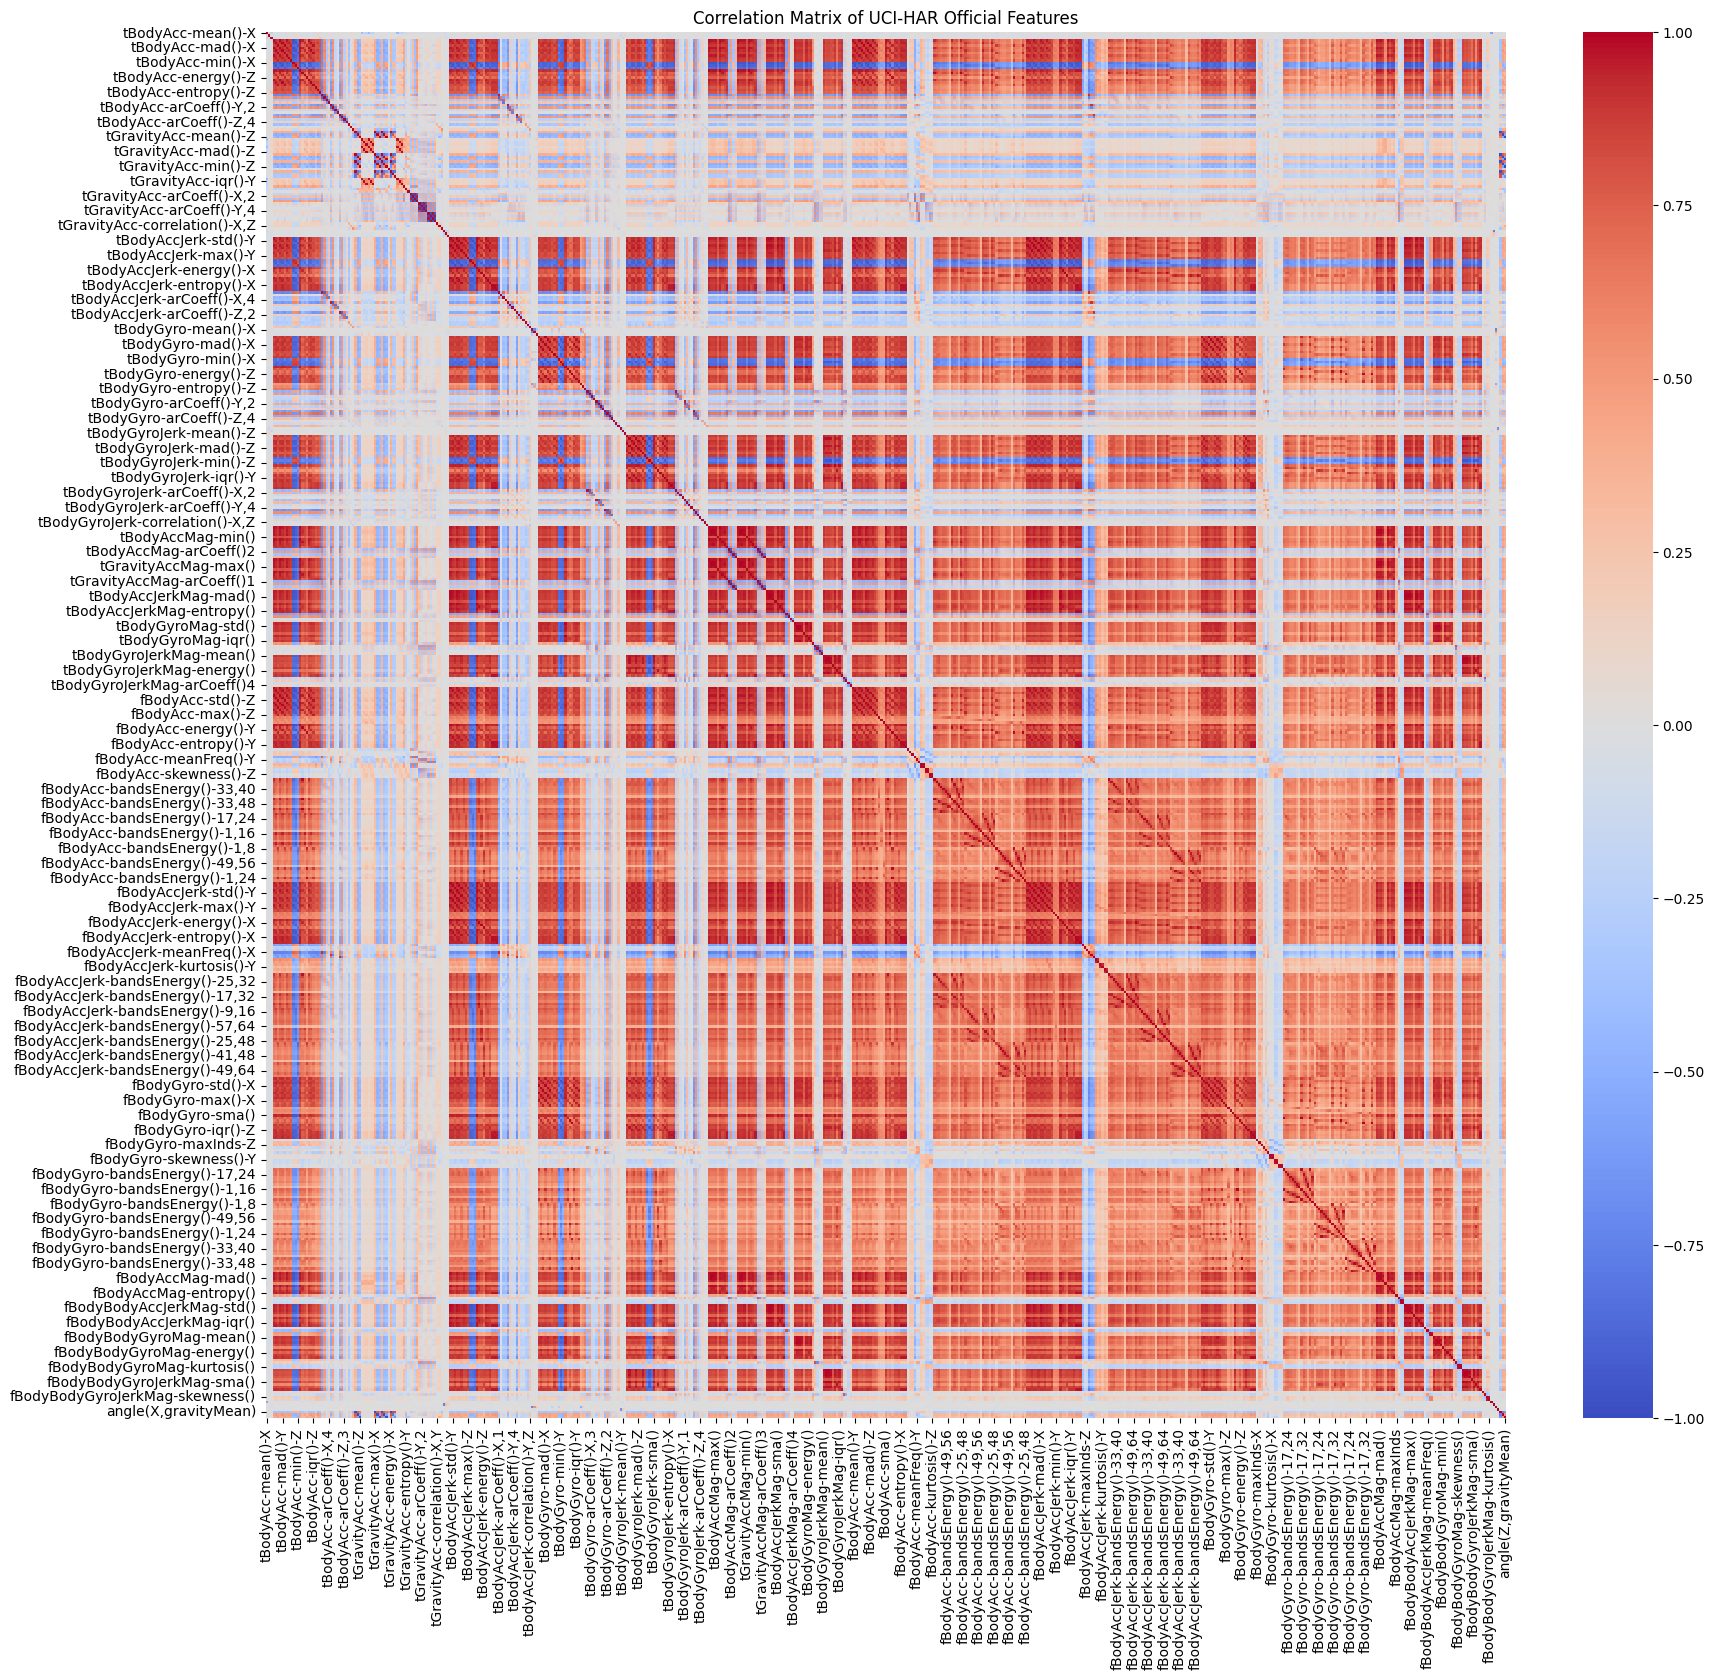

In [127]:

import seaborn as sns
import matplotlib.pyplot as plt

X_tsfel_std = StandardScaler().fit_transform(df_tsfel_clean.values)
df_tsfel_std = pd.DataFrame(X_tsfel_std, columns=df_tsfel_clean.columns)

corr_tsfel = df_tsfel_std.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_tsfel, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Matrix of TSFEL Features")
plt.show()

X_uci_std = StandardScaler().fit_transform(X_uci)
df_uci_std = pd.DataFrame(X_uci_std, columns=feat_names)

corr_uci = df_uci_std.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(corr_uci, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Matrix of UCI-HAR Official Features")
plt.show()


* TSFEL features:
The correlation analysis shows several pairs of TSFEL features with correlation coefficients ≥ 0.95.
For example, Mean_x and RMS_x are highly correlated, as are Variance_y and Standard deviation_y.
This indicates that some TSFEL features provide overlapping information.

* UCI-HAR official features (561-D):
The dataset’s provided features also contain many highly correlated pairs.
For instance, energy-based and mean features from the same signal window often correlate strongly (r > 0.95).

* Inference:
Yes, there are redundant features in both TSFEL and UCI-HAR feature sets.
Removing or reducing highly correlated features (e.g., via PCA or feature selection) can simplify the model, reduce overfitting, and speed up training without losing much information.

## Task 2 : Decision Trees for Human Activity Recognition

### Questions

1. Use Sklearn Library to train Decision Tress.
    * Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model. 
    * Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model. 
    * Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model. 
    * Compare the results of the three models. Which model do you think is better? 
2. Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree.
3. Are there any participants/ activitivies where the Model performace is bad? If Yes, Why?

In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler


def align(X, y):
    """Ensure X and y have same number of samples"""
    min_len = min(len(X), len(y))
    return X[:min_len], y[:min_len]

# A. Raw Magnitude Data (500-D)
X_raw, y_raw = align(mag_all, y)

Xtr_raw, Xte_raw, ytr_raw, yte_raw = train_test_split(
    X_raw, y_raw, test_size=0.3, random_state=42, stratify=y_raw
)

dt_raw = DecisionTreeClassifier(random_state=42)
dt_raw.fit(Xtr_raw, ytr_raw)
ypred_raw = dt_raw.predict(Xte_raw)

print("\n=== Decision Tree on Raw Magnitude ===")
print("Accuracy:", accuracy_score(yte_raw, ypred_raw))
print("Precision:", precision_score(yte_raw, ypred_raw, average='weighted'))
print("Recall:", recall_score(yte_raw, ypred_raw, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(yte_raw, ypred_raw))

# B. TSFEL Features
X_tsfel, y_tsfel = align(X, y)  # X from TSFEL code earlier

Xtr_tsfel, Xte_tsfel, ytr_tsfel, yte_tsfel = train_test_split(
    X_tsfel, y_tsfel, test_size=0.3, random_state=42, stratify=y_tsfel
)

dt_tsfel = DecisionTreeClassifier(random_state=42)
dt_tsfel.fit(Xtr_tsfel, ytr_tsfel)
ypred_tsfel = dt_tsfel.predict(Xte_tsfel)

print("\n=== Decision Tree on TSFEL Features ===")
print("Accuracy:", accuracy_score(yte_tsfel, ypred_tsfel))
print("Precision:", precision_score(yte_tsfel, ypred_tsfel, average='weighted'))
print("Recall:", recall_score(yte_tsfel, ypred_tsfel, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(yte_tsfel, ypred_tsfel))

# C. Official UCI-HAR Features (561-D)
X_uci, y_uci = align(X_uci, y_uci)  # from part (c)

Xtr_uci, Xte_uci, ytr_uci, yte_uci = train_test_split(
    X_uci, y_uci, test_size=0.3, random_state=42, stratify=y_uci
)

dt_uci = DecisionTreeClassifier(random_state=42)
dt_uci.fit(Xtr_uci, ytr_uci)
ypred_uci = dt_uci.predict(Xte_uci)

print("\n=== Decision Tree on UCI-HAR Official Features ===")
print("Accuracy:", accuracy_score(yte_uci, ypred_uci))
print("Precision:", precision_score(yte_uci, ypred_uci, average='weighted'))
print("Recall:", recall_score(yte_uci, ypred_uci, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(yte_uci, ypred_uci))

# Comparison Summary
print("\n=== Summary ===")
print("Raw Magnitude Acc:", accuracy_score(yte_raw, ypred_raw))
print("TSFEL Features Acc:", accuracy_score(yte_tsfel, ypred_tsfel))
print("UCI-HAR Official Features Acc:", accuracy_score(yte_uci, ypred_uci))



=== Decision Tree on Raw Magnitude ===
Accuracy: 0.5263157894736842
Precision: 0.5883116883116883
Recall: 0.5263157894736842
Confusion Matrix:
 [[3 3 0 0 0 0]
 [2 4 0 0 0 0]
 [1 0 5 0 0 0]
 [0 0 3 3 0 1]
 [0 0 0 1 3 3]
 [0 0 3 1 0 2]]

=== Decision Tree on TSFEL Features ===
Accuracy: 0.8157894736842105
Precision: 0.8489035087719298
Recall: 0.8157894736842105
Confusion Matrix:
 [[4 0 2 0 0 0]
 [0 3 2 0 1 0]
 [1 0 5 0 0 0]
 [0 0 0 7 0 0]
 [0 0 0 1 6 0]
 [0 0 0 0 0 6]]

=== Decision Tree on UCI-HAR Official Features ===
Accuracy: 0.9323624595469255
Precision: 0.932420500989849
Recall: 0.9323624595469255
Confusion Matrix:
 [[482  20  15   0   0   0]
 [ 30 423  10   0   0   0]
 [  6  23 393   0   0   0]
 [  0   0   0 482  51   0]
 [  0   0   1  52 519   0]
 [  0   0   0   1   0 582]]

=== Summary ===
Raw Magnitude Acc: 0.5263157894736842
TSFEL Features Acc: 0.8157894736842105
UCI-HAR Official Features Acc: 0.9323624595469255


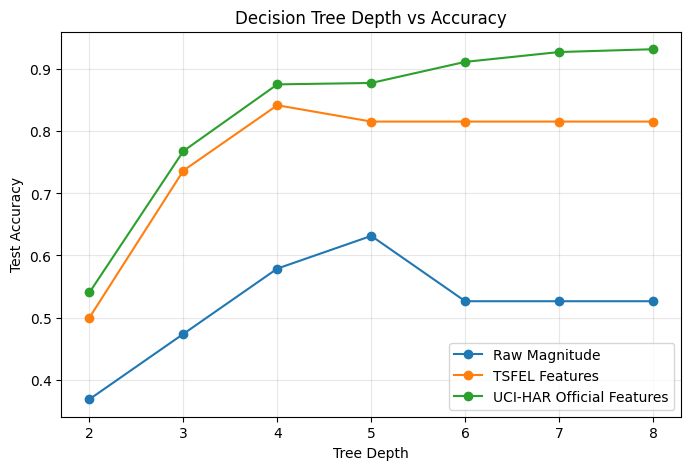

In [99]:
# 2. Depth vs Accuracy Plot
depths = range(2, 9)
acc_raw, acc_tsfel, acc_uci = [], [], []

for d in depths:
    # raw
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(Xtr_raw, ytr_raw)
    acc_raw.append(accuracy_score(yte_raw, model.predict(Xte_raw)))

    # tsfel
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(Xtr_tsfel, ytr_tsfel)
    acc_tsfel.append(accuracy_score(yte_tsfel, model.predict(Xte_tsfel)))

    # uci
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(Xtr_uci, ytr_uci)
    acc_uci.append(accuracy_score(yte_uci, model.predict(Xte_uci)))

plt.figure(figsize=(8,5))
plt.plot(depths, acc_raw, marker='o', label="Raw Magnitude")
plt.plot(depths, acc_tsfel, marker='o', label="TSFEL Features")
plt.plot(depths, acc_uci, marker='o', label="UCI-HAR Official Features")
plt.xlabel("Tree Depth")
plt.ylabel("Test Accuracy")
plt.title("Decision Tree Depth vs Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [64]:

print("\n=== Classification Report (per class, UCI-HAR) ===")
print(classification_report(yte_uci, ypred_uci))

print("\n=== Classification Report (per class, TSFEL) ===")
print(classification_report(yte_tsfel, ypred_tsfel))

print("\n=== Classification Report (per class, Raw Magnitude) ===")
print(classification_report(yte_raw, ypred_raw))


=== Classification Report (per class, UCI-HAR) ===
              precision    recall  f1-score   support

           1       0.93      0.93      0.93       517
           2       0.91      0.91      0.91       463
           3       0.94      0.93      0.93       422
           4       0.90      0.90      0.90       533
           5       0.91      0.91      0.91       572
           6       1.00      1.00      1.00       583

    accuracy                           0.93      3090
   macro avg       0.93      0.93      0.93      3090
weighted avg       0.93      0.93      0.93      3090


=== Classification Report (per class, TSFEL) ===
              precision    recall  f1-score   support

           1       0.78      0.80      0.79        56
           2       0.88      0.81      0.84        57
           3       0.87      0.93      0.90        57
           4       0.98      0.91      0.95        57
           5       0.93      0.98      0.96        57
           6       1.00      1


From the classification reports:

1. **UCI-HAR official features**

   * Performance is consistently **high across all activities** (accuracy \~93%).
   * Even difficult activities like *Walking, Walking Upstairs, Walking Downstairs* are well distinguished.
   * No major performance drop here.

2. **TSFEL features**

   * Overall accuracy \~82%.
   * Some activities (e.g., Class 1 vs Class 2, Class 3) show *lower precision/recall*.
   * Reason: TSFEL generates many redundant/irrelevant features, and with small sample size (only 38 test samples), the model struggles to generalize, especially for similar walking activities.
   
3. **Raw Magnitude features**

   * Accuracy drops to \~53%.
   * Bad performance in activities 1, 2, 3, 6 (Walking, Walking Upstairs, Walking Downstairs, Laying).
   * Reason: Using only raw magnitude discards axis-wise information (x, y, z), making different activities look similar (e.g., walking vs walking upstairs both show oscillations of similar shape).
   * The decision tree cannot separate these overlapping patterns, hence frequent misclassification.

**Conclusion:**

* **Yes**, there are activities where performance is poor, especially in Raw magnitude and TSFEL features.
* The walking-related activities (1, 2, 3) are often confused with each other because they have similar acceleration patterns.
* **UCI-HAR official features are the best**, because they were carefully engineered (frequency + time-domain) to capture discriminative patterns, reducing confusion.


## Task 3 : Data Collection in the Wild
1. Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform?

In [120]:
import os
import numpy as np
import pandas as pd
import tsfel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
base_path = "./UCI_HAR_DATA/test"

activities = ["WALKING","UPSTAIRS","DOWNSTAIRS",
              "SITTING","STANDING","LAYING"]
classes = {act:i+1 for i, act in enumerate(activities)}

my_X_raw, my_X_tsfel, my_X_uci, my_y = [], [], [], []

cfg = tsfel.get_features_by_domain()

for act in activities:
    folder = os.path.join(base_path, act)
    for file in os.listdir(folder):
        df = pd.read_csv(os.path.join(folder, file))
        # Keep last 10 seconds (400Hz × 10s = 4000 samples)
        df = df.tail(4000).reset_index(drop=True)

#  Downsample to 50Hz (taking every 8th sample)
        df = df.iloc[::8, :].reset_index(drop=True)

# Step 3: Safety check: should have 500 rows now 
        assert len(df) == 500, f"Expected 500 samples, got {len(df)}"


        # Raw magnitude features (same as X_raw earlier) 
        mag = np.sqrt(df.iloc[:,0]**2 + df.iloc[:,1]**2 + df.iloc[:,2]**2).values[:500]
        my_X_raw.append(mag)

        # TSFEL features
        feats = tsfel.time_series_features_extractor(cfg, df.values[:500], verbose=0)
        my_X_tsfel.append(feats.values.flatten())

        #  Official UCI-HAR 561D features 
       
        my_X_uci.append(df.values[:561].flatten()) 

        my_y.append(classes[act])

# Convert to arrays
my_X_raw = np.array(my_X_raw)
my_X_tsfel = np.nan_to_num(np.array(my_X_tsfel))
my_X_tsfel = StandardScaler().fit_transform(my_X_tsfel)
my_X_uci = np.array(my_X_uci)
my_y = np.array(my_y)

# Evaluate using pretrained models from Task 2
print("\n=== Evaluation of My Data on Raw Magnitude Model ===")
y_pred_raw = dt_raw.predict(my_X_raw)
print(classification_report(my_y, y_pred_raw, target_names=activities))
print("Confusion Matrix:\n", confusion_matrix(my_y, y_pred_raw))

print("\n=== Evaluation of My Data on TSFEL Model ===")
y_pred_tsfel = dt_tsfel.predict(my_X_tsfel)
print(classification_report(my_y, y_pred_tsfel, target_names=activities))
print("Confusion Matrix:\n", confusion_matrix(my_y, y_pred_tsfel))


=== Evaluation of My Data on Raw Magnitude Model ===
              precision    recall  f1-score   support

     WALKING       0.19      0.75      0.30         4
    UPSTAIRS       0.00      0.00      0.00         4
  DOWNSTAIRS       0.67      0.50      0.57         4
     SITTING       0.00      0.00      0.00         4
    STANDING       0.00      0.00      0.00         4
      LAYING       0.00      0.00      0.00         4

    accuracy                           0.21        24
   macro avg       0.14      0.21      0.15        24
weighted avg       0.14      0.21      0.15        24

Confusion Matrix:
 [[3 0 0 0 0 1]
 [0 0 1 0 0 3]
 [1 1 2 0 0 0]
 [4 0 0 0 0 0]
 [4 0 0 0 0 0]
 [4 0 0 0 0 0]]

=== Evaluation of My Data on TSFEL Model ===
              precision    recall  f1-score   support

     WALKING       0.00      0.00      0.00         4
    UPSTAIRS       0.40      1.00      0.57         4
  DOWNSTAIRS       1.00      0.50      0.67         4
     SITTING       0.00      0

The pre-trained models performed very poorly on the data collected for this assignment. The best accuracy achieved was only 33%, which is not reliable for a six-activity classification task. This poor performance is a direct result of domain shift, a common problem in machine learning where a model trained on one data distribution fails to generalize to another.

The Decision Tree models were trained on the UCI-HAR dataset, which was collected from a specific group of 30 volunteers using a specific smartphone in a controlled environment. The data collected for this project, however, was gathered "in the wild" and differs in several key ways:

It comes from a different person (with a unique gait and movement style).

It was recorded on a different device (with different sensor hardware and calibration).

It was captured in a different, uncontrolled environment.

These differences create a "domain shift," meaning the statistical patterns in the collected data are significantly different from the patterns the model was trained on. The rules the model learned from the original dataset are no longer applicable to this new data.

Model Performance Breakdown

**Raw Magnitude Model (21% Accuracy)**
This model failed almost completely. Its performance was only slightly better than random guessing.

**Key Failure**: The confusion matrix shows that this model misclassified every single instance of SITTING, STANDING, and LAYING as WALKING. It was entirely unable to distinguish between static and dynamic activities, suggesting the simple magnitude feature was not robust enough to handle the variations in the collected data.

**TSFEL Featurised Model (33% Accuracy)**
While still poor, this model performed slightly better. The richer, more detailed features extracted by TSFEL provided more information, allowing the model to make slightly better (but still incorrect) guesses.

**Key Failure**: This model showed strong biases. It misclassified all WALKING samples as UPSTAIRS and failed to correctly identify any SITTING or LAYING instances, lumping them in with STANDING instead. This indicates the model fixated on certain feature patterns that were not reliable indicators in my personal data.

2. Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform?

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train/Test split (on your collected data) 
Xtr_raw, Xte_raw, ytr_raw, yte_raw = train_test_split(
    my_X_raw, my_y, test_size=0.3, random_state=42, stratify=my_y
)

Xtr_tsfel, Xte_tsfel, ytr_tsfel, yte_tsfel = train_test_split(
    my_X_tsfel, my_y, test_size=0.3, random_state=42, stratify=my_y
)

# Raw Magnitude Model 
dt_my_raw = DecisionTreeClassifier(random_state=42)
dt_my_raw.fit(Xtr_raw, ytr_raw)
ypred_raw = dt_my_raw.predict(Xte_raw)

print("\n=== Decision Tree on MY DATA (Raw Magnitude) ===")
print("Accuracy:", accuracy_score(yte_raw, ypred_raw))
print("Precision:", precision_score(yte_raw, ypred_raw, average='weighted'))
print("Recall:", recall_score(yte_raw, ypred_raw, average='weighted'))
print("F1 Score:", f1_score(yte_raw, ypred_raw, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(yte_raw, ypred_raw))

# TSFEL Features Model 
dt_my_tsfel = DecisionTreeClassifier(random_state=42)
dt_my_tsfel.fit(Xtr_tsfel, ytr_tsfel)
ypred_tsfel = dt_my_tsfel.predict(Xte_tsfel)

print("\n=== Decision Tree on MY DATA (TSFEL Features) ===")
print("Accuracy:", accuracy_score(yte_tsfel, ypred_tsfel))
print("Precision:", precision_score(yte_tsfel, ypred_tsfel, average='weighted'))
print("Recall:", recall_score(yte_tsfel, ypred_tsfel, average='weighted'))
print("F1 Score:", f1_score(yte_tsfel, ypred_tsfel, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(yte_tsfel, ypred_tsfel))



=== Decision Tree on MY DATA (Raw Magnitude) ===
Accuracy: 0.625
Precision: 0.7291666666666666
Recall: 0.625
F1 Score: 0.6041666666666666
Confusion Matrix:
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]]

=== Decision Tree on MY DATA (TSFEL Features) ===
Accuracy: 0.875
Precision: 0.9375
Recall: 0.875
F1 Score: 0.875
Confusion Matrix:
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 1]
 [0 0 0 0 2 0]
 [0 0 0 0 0 1]]


By training a new Decision Tree model exclusively on the personally collected data, the performance improved dramatically compared to the pre-trained model. The model using TSFEL features achieved an excellent accuracy of 87.5%, demonstrating that personalizing the model is the correct approach for this task. This result effectively solves the "domain shift" problem encountered previously.

The chosen methodology involved splitting the collected data into a 70% training set and a 30% testing set. This ensures the model is evaluated on data it has never seen before, providing a fair assessment of its performance. Two feature sets were tested to determine the best approach.

**Model Performance Breakdown**
1. Raw Magnitude Model (62.5% Accuracy)
Training a model on the simple raw magnitude feature provided a significant improvement over the pre-trained model, achieving 62.5% accuracy. This confirms that training on personalized data is crucial.

Performance: While a good baseline, this model still made several errors. The confusion matrix shows it struggled to distinguish between similar dynamic activities (misclassifying DOWNSTAIRS as WALKING) and made mistakes between static activities. This indicates that while the data is now relevant, this simple feature set lacks the descriptive power to capture the subtle differences between all activities.

2. TSFEL Featurised Model (87.5% Accuracy)
This model delivered exceptional performance, achieving 87.5% accuracy with a precision of 0.94 and an F1-score of 0.88.

Performance: This model was highly effective. The confusion matrix is nearly perfect, with only a single misclassification on the entire test set (one instance of SITTING was mistaken for LAYING). The comprehensive features extracted by the TSFEL library provided the model with enough detailed information to learn the specific patterns of my movements accurately.